# TASK 1

##### Using PySpark DataFrame

### Loading the Dataset

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, countDistinct, lit, when, lower, desc, month, explode, split, expr, to_date, unix_timestamp, to_date, year, datediff
import csv
from io import StringIO
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

In [0]:
%python
dbutils.fs.ls("/FileStore/tables/")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1712156823000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1715218433000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1712694645000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1715218430000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1712694645000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1715218424000),
 FileInfo(path='dbfs:/FileStore/tables/clini

In [0]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Clinical Trials Analysis with DataFrames") \
    .getOrCreate()

# Access SparkContext
sc = spark.sparkContext

In [0]:
# Defining the Clinicaltrial schema
Clinical_Schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Study Title", StringType(), True),
    StructField("Acronym", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Conditions", StringType(), True),
    StructField("Interventions", StringType(), True),
    StructField("Sponsor", StringType(), True),
    StructField("Collaborators", StringType(), True),
    StructField("Enrollment", StringType(), True),
    StructField("Funder Type", StringType(), True),
    StructField("Type", StringType(), True),
    StructField("Study Design", StringType(), True),
    StructField("Start", StringType(), True),
    StructField("Completion", StringType(), True)])

# Load the RDD from text file
Clinical_rdd = sc.textFile("/FileStore/tables/clinicaltrial_2023.csv")

In [0]:
%python
# Defining the Pharma schema
Pharma_Schema = StructType([
    StructField("Company", StringType(), True),
    StructField("Parent_Company", StringType(), True),
    StructField("Penalty_Amount", StringType(), True), 
    StructField("Subtraction_From_Penalty", StringType(), True),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", StringType(), True),
    StructField("Penalty_Year", StringType(), True),
    StructField("Penalty_Date", StringType(), True), 
    StructField("Offense_Group", StringType(), True),
    StructField("Primary_Offense", StringType(), True),
    StructField("Secondary_Offense", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Level_of_Government", StringType(), True),
    StructField("Action_Type", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Civil/Criminal", StringType(), True),
    StructField("Prosecution_Agreement", StringType(), True),
    StructField("Court", StringType(), True),
    StructField("Case_ID", StringType(), True),
    StructField("Private_Litigation_Case_Title", StringType(), True),
    StructField("Lawsuit_Resolution", StringType(), True),
    StructField("Facility_State", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Zip", StringType(), True),
    StructField("NAICS_Code", StringType(), True),
    StructField("NAICS_Translation", StringType(), True),
    StructField("HQ_Country_of_Parent", StringType(), True),
    StructField("HQ_State_of_Parent", StringType(), True),
    StructField("Ownership_Structure", StringType(), True),
    StructField("Parent_Company_Stock_Ticker", StringType(), True),
    StructField("Major_Industry_of_Parent", StringType(), True),
    StructField("Specific_Industry_of_Parent", StringType(), True),
    StructField("Info_Source", StringType(), True),
    StructField("Notes", StringType(), True)
])

# Load the RDD from text file
Pharma_rdd = sc.textFile("/FileStore/tables/pharma.csv")

### Cleaning the data

In [0]:
%python
# Cleaning Clinicaltrial_2023
# Removing commas, double quotes and splitting the data
Cleaned_Clinical_rdd = Clinical_rdd.map(lambda line: line.replace(',,', ',').replace('"', ''))\
                                   .map(lambda x: x.split('\t'))\
                                   .map(lambda row: row[:-1] + [row[-1].split(',')[0]] if row[-1] else row)  

# Replace missing or empty values with 'NA', ensuring the row length matches the schema
Cleaned_Clinical_rdd = Cleaned_Clinical_rdd.map(lambda row: ['NA' if not value else value for value in row])\
                                           .map(lambda row: row if len(row) == len(Clinical_Schema.fields) else row + ['NA'] * (len(Clinical_Schema.fields) - len(row)))


# Retrieving and Filtering out the header
header_Clinical_rdd = Cleaned_Clinical_rdd.first() 
Cleaned_Clinical_rdd = Cleaned_Clinical_rdd.filter(lambda row: row != header_Clinical_rdd)  

# Create DataFrame
Cleaned_Clinical_df = spark.createDataFrame(Cleaned_Clinical_rdd, Clinical_Schema)  

# View results
Cleaned_Clinical_df.show(5)


+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|   Acronym|            Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|NCT03630471|Effectiveness of ...|     PRIDE|         COMPLETED|Mental Health Iss...|BEHAVIORAL: PRIDE...|             Sangath|Harvard Medical S...|     250.0|      OTHER|INTERVENTIONAL|Allocation: RANDO...|2018-08-20|2019-02-28|
|NCT05992571|Oral Ketone Monoe...|        NA|        RECRUITING|Cerebrovascular 

In [0]:
%python

# Cleaning Pharma
# Removing all double quotation marks from each line and handling parsing
Cleaned_Pharma_rdd = Pharma_rdd.map(lambda line: next(csv.reader(StringIO(line), delimiter=',')))

# Replace missing values with 'NA' for each row
Cleaned_Pharma_rdd = Cleaned_Pharma_rdd.map(lambda row: ['NA' if not value else value for value in row])

# Ensuring each row has exactly the number of fields as in Pharma_Schema
Cleaned_Pharma_rdd = Cleaned_Pharma_rdd.map(lambda row: row if len(row) == len(Pharma_Schema.fields) else row + ['NA'] * (len(Pharma_Schema.fields) - len(row)))

# Retrieving and Filtering out the header row
header_Pharma_rdd = Cleaned_Pharma_rdd.first()

Cleaned_Pharma_rdd = Cleaned_Pharma_rdd.filter(lambda row: row != header_Pharma_rdd)

# Since there's no mention of a header to be removed for Pharma_rdd, we proceed directly to DataFrame creation
Cleaned_Pharma_df = spark.createDataFrame(Cleaned_Pharma_rdd, Pharma_Schema)

# Show the result to verify
Cleaned_Pharma_df.show(5)

+--------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+-------+-----------------------------+------------------+--------------+--------+-------+---+----------+--------------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+--------------------+
|             Company|     Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    Civil/Criminal|Prosecution_Agr

### Questions



### No. 1

In [0]:
distinct_studies = Cleaned_Clinical_df.select(countDistinct("Id").alias("Distinct Studies"))
distinct_studies.show()

+----------------+
|Distinct Studies|
+----------------+
|          483422|
+----------------+



### No. 2

In [0]:
from pyspark.sql.functions import col, desc

study_types_frequency = Cleaned_Clinical_df.groupBy("Type").count().orderBy(desc("count"))
study_types_frequency.show()


+---------------+------+
|           Type| count|
+---------------+------+
| INTERVENTIONAL|371382|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
|             NA|   891|
+---------------+------+



### No. 3

In [0]:
top_5_conditions = Cleaned_Clinical_df.groupBy("Conditions").count().orderBy(desc("count")).limit(5)
top_5_conditions.show()

+---------------+-----+
|     Conditions|count|
+---------------+-----+
|        Healthy| 7997|
|  Breast Cancer| 4556|
|Prostate Cancer| 2650|
|         Asthma| 2309|
|        Obesity| 2284|
+---------------+-----+



### No. 4

In [0]:
# Ensure case-insensitive comparison by converting relevant columns to lowercase
clinical_lower = Cleaned_Clinical_df.withColumn("Sponsor_lower", lower(col("Sponsor")))
pharma_lower = Cleaned_Pharma_df.select(lower(col("Parent_Company")).alias("Parent_Company_lower")).distinct()

# Perform a left anti join to find sponsors in clinical_lower not present in pharma_lower
non_pharma_sponsors = clinical_lower.join(pharma_lower, clinical_lower.Sponsor_lower == pharma_lower.Parent_Company_lower, "left_anti")

# Group by the original Sponsor column (not the lowercase version), count, and order by count descending
top_10_non_pharma_sponsors = non_pharma_sponsors.groupBy("Sponsor").count().orderBy(desc("count")).limit(10)

top_10_non_pharma_sponsors.show()

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3410|
|   Assiut University| 3335|
|    Cairo University| 3023|
|Assistance Publiq...| 2951|
|         Mayo Clinic| 2766|
|M.D. Anderson Can...| 2702|
|Novartis Pharmace...| 2393|
|National Institut...| 2340|
|Massachusetts Gen...| 2263|
|National Taiwan U...| 2181|
+--------------------+-----+



### No. 5

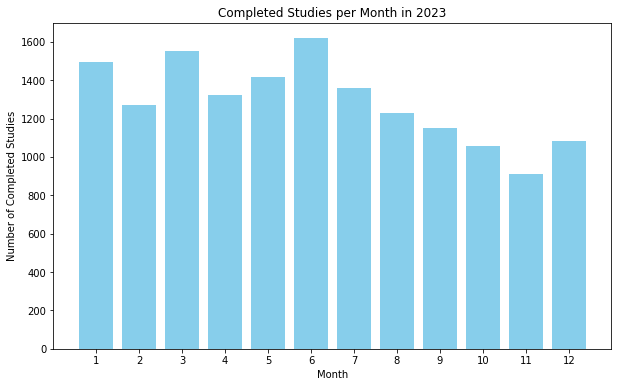

In [0]:
# Filter for completed studies in 2023
completed_studies_2023 = Cleaned_Clinical_df.filter((col("Status") == "COMPLETED") & (year(col("Completion")) == 2023))

# Count studies by month
monthly_counts = completed_studies_2023.groupBy(month("Completion").alias("Month")).count().orderBy("Month")

# Collect data for plotting
monthly_data = monthly_counts.collect()

# Plot
months = [row['Month'] for row in monthly_data]
counts = [row['count'] for row in monthly_data]
plt.figure(figsize=(10, 6))
plt.bar(months, counts, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Completed Studies per Month in 2023')
plt.xticks(months)
plt.show()

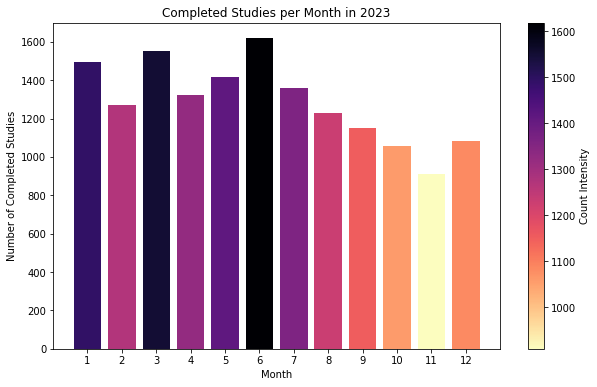

In [0]:
# Filter for completed studies in 2023
completed_studies_2023 = Cleaned_Clinical_df.filter((col("Status") == "COMPLETED") & (year(col("Completion")) == 2023))

# Count studies by month
monthly_counts = completed_studies_2023.groupBy(month("Completion").alias("Month")).count().orderBy("Month")

# Plot
monthly_data = monthly_counts.collect()
months, counts = zip(*[(row['Month'], row['count']) for row in monthly_data])

# Using Magma palette
norm = plt.Normalize(min(counts), max(counts))
colors = cm.magma_r(norm(counts))

plt.figure(figsize=(10, 6))
bars = plt.bar(months, counts, color=colors)

# Adding color bar for reference
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='magma_r'), label='Count Intensity')

plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Completed Studies per Month in 2023')
plt.xticks(months)
plt.show()

In [0]:
# Display table of values
monthly_counts.show()

+-----+-----+
|Month|count|
+-----+-----+
|    1| 1494|
|    2| 1272|
|    3| 1552|
|    4| 1324|
|    5| 1415|
|    6| 1619|
|    7| 1360|
|    8| 1230|
|    9| 1152|
|   10| 1058|
|   11|  909|
|   12| 1082|
+-----+-----+



### No. 6(b)

In [0]:
from pyspark.sql.functions import to_date, year, datediff

# Assuming 'Cleaned_Clinical_df' is your DataFrame with 'Start' and 'Completion' columns as strings
# Convert 'Start' and 'Completion' to date types
Cleaned_Clinical_df = Cleaned_Clinical_df.withColumn("Start", to_date("Start", "yyyy-MM-dd")) \
                         .withColumn("Completion", to_date("Completion", "yyyy-MM-dd"))

# Calculate duration in days and extract start year
Cleaned_Clinical_df = Cleaned_Clinical_df.withColumn("Duration", datediff("Completion", "Start")) \
                         .withColumn("Year", year("Start"))

# Filter out rows where either date is null or Duration is negative
Cleaned_Clinical_df = Cleaned_Clinical_df.filter((Cleaned_Clinical_df.Duration >= 0) & (Cleaned_Clinical_df.Year.isNotNull()))

# Calculate average duration by year
avg_duration_df = Cleaned_Clinical_df.groupBy("Year").avg("Duration").orderBy("Year")

# Show the DataFrame to verify
avg_duration_df.show()

+----+------------------+
|Year|     avg(Duration)|
+----+------------------+
|1916|           38562.0|
|1917|             364.0|
|1963|           21775.0|
|1968|           18536.0|
|1972|           16695.0|
|1973|           18261.5|
|1975|           14579.0|
|1976|            8943.5|
|1977|           14009.5|
|1979|           14647.0|
|1980|           10207.0|
|1981|            7987.5|
|1983| 8525.333333333334|
|1984|         15237.125|
|1985|           11412.5|
|1986|           12107.5|
|1987| 9196.333333333334|
|1988|10676.666666666666|
|1989| 9005.666666666666|
|1990| 9434.333333333334|
+----+------------------+
only showing top 20 rows



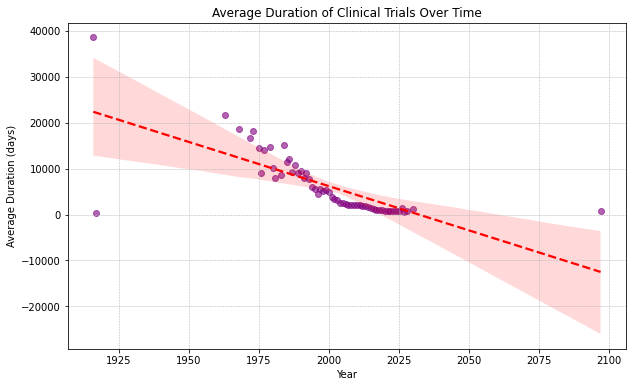

In [0]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
pd_avg_duration = avg_duration_df.toPandas()

# Using Seaborn to plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Year', y='avg(Duration)', data=pd_avg_duration, scatter_kws={'color': 'purple', 'alpha': 0.6}, line_kws={'color': 'red', 'linestyle': '--'})

plt.title('Average Duration of Clinical Trials Over Time')
plt.xlabel('Year')
plt.ylabel('Average Duration (days)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### Extra Features

### Resuasble Code for 2020 & 2023
###### This series of codes and functions below can load, clean and analyze data for any year inputed (I.e 2020 or 2021)

In [0]:
# Define the configuration for dataset loading based on year
def get_dataset_config(year):
    dataset_configs = {
        '2020': {'delimiter': '|', 'remove_quotes': True, 'fill_missing': True},
        '2021': {'delimiter': '|', 'remove_quotes': True, 'fill_missing': True},
    }
    return dataset_configs.get(str(year), {})

In [0]:
# DataFrame Load and clean data function
def load_and_clean_data(file_path, config):
    clinical_data = spark.read.option("header", "true") \
                              .option("delimiter", config['delimiter']) \
                              .option("quote", '"' if config['remove_quotes'] else "") \
                              .csv(file_path)
    
    if config['fill_missing']:
        for column in clinical_data.columns:
            clinical_data = clinical_data.withColumn(column, when(col(column).isNull() | (col(column) == ""), lit("NA")).otherwise(col(column)))
    
    return clinical_data

In [0]:
# Function to load and prepare pharma_df
def load_and_prepare_pharma_data():
    file_path = "/FileStore/tables/pharma.csv"
    config = {
        'delimiter': ',',
        'remove_quotes': True,
        'fill_missing': True
    }
    pharma_df = spark.read.option("header", "true") \
                          .option("delimiter", config['delimiter']) \
                          .option("quote", '"' if config['remove_quotes'] else "") \
                          .csv(file_path)
    
    if config['fill_missing']:
        for column in pharma_df.columns:
            pharma_df = pharma_df.withColumn(column, when(col(column).isNull() | (col(column) == ""), lit("NA")).otherwise(col(column)))
    
    return pharma_df

# Load and prepare pharma_df
pharma_df = load_and_prepare_pharma_data()

In [0]:
# Global variables
year_global = None
df = None

In [0]:
# Function to load data based on input year
def process_clinical_trials_data_with_input():
    global year_global, df
    available_years = ['2020', '2021']
    year_global = input("Input clinical trial year (available years are 2020, 2021): ")
    if year_global in available_years:
        config = get_dataset_config(year_global)
        file_path = f"/FileStore/tables/clinicaltrial_{year_global}.csv"
        df = load_and_clean_data(file_path, config)
    else:
        print(f"The year {year_global} is not available. Please choose from {', '.join(available_years)}.")

In [0]:
# Analysis functions
def analysis_1_number_of_studies():
    if df is not None:
        distinct_studies_count = df.select("Id").distinct().count()
        print(f"Number of distinct studies for {year_global}: {distinct_studies_count}")
    else:
        print("Data not loaded. Please run the data loading cell correctly.")

def analysis_2_study_type_frequencies():
    if df is not None:
        type_frequencies = df.groupBy("Type").count().orderBy("count", ascending=False)
        print(f"Study Type Frequencies for {year_global}:")
        type_frequencies.show()
    else:
        print("Data not loaded. Please run the data loading cell correctly.")

def analysis_3_top_conditions():
    if df is not None:
        top_conditions = df.withColumn("Condition", explode(split(col("Conditions"), ","))) \
                            .filter(col("Condition") != 'NA') \
                            .groupBy("Condition") \
                            .count() \
                            .orderBy(col("count").desc()) \
                            .limit(5)
        print(f"Top 5 Conditions (excluding 'NA') for {year_global}:")
        top_conditions.show()
    else:
        print("Data not loaded. Please run the data loading cell correctly.")

def analysis_4_top_non_pharma_sponsors():
    if df is not None and pharma_df is not None:
        pharma_companies_list = [row["Parent_Company"] for row in pharma_df.select("Parent_Company").distinct().collect()]
        non_pharma_df = df.filter(~col("Sponsor").isin(pharma_companies_list))
        top_10_sponsors = non_pharma_df.groupBy("Sponsor").count().orderBy("count", ascending=False).limit(10)
        print(f"Top 10 Non-Pharmaceutical Sponsors for {year_global}:")
        top_10_sponsors.show()
    else:
        print("Data not loaded or pharmaceutical data missing. Please run the data loading cells correctly.")

In [0]:
def analysis_5_completed_studies_by_month():
    global df, year_global  # Use global variables for DataFrame and year
    if df is not None:
        # Combine filtering and month extraction into one line
        completed_studies = df.filter((col("Status") == "Completed") & col("Completion").endswith(year_global)) \
                              .withColumn("Month", month(to_date(col("Completion"), "MMM yyyy"))) \
                              .groupBy("Month").count().orderBy("Month")
        
        completed_count = completed_studies.count()  # Compute count once

        # Check if there are completed studies and plot results
        if completed_count > 0:
            # Convert to Pandas for plotting
            pd_completed_studies = completed_studies.toPandas()
            pd_completed_studies['MonthName'] = pd_completed_studies['Month'].apply(lambda x: datetime(1900, x, 1).strftime('%B'))
            
            # Plotting directly
            plt.figure(figsize=(10, 6))
            plt.bar(pd_completed_studies['MonthName'], pd_completed_studies['count'], color='skyblue')
            plt.xlabel('Month')
            plt.ylabel('Number of Completed Studies')
            plt.title(f'Completed Studies per Month in {year_global}')
            plt.xticks(rotation=45)
            plt.show()

            # Display the DataFrame after plotting
            print("\nCompleted Studies per Month:")
            completed_studies.show()  # This shows the Spark DataFrame in tabular form
        else:
            print(f"No completed studies found for the year {year_global}.")
    else:
        print("Data not loaded. Please run the data loading cell correctly.")

In [0]:
# Calling the function to insert a year of interest
# Insert a year "2020 or 2021"
process_clinical_trials_data_with_input()

Input clinical trial year (available years are 2020, 2021):  2020

In [0]:
analysis_1_number_of_studies()

Number of distinct studies for 2020: 356466


In [0]:
analysis_2_study_type_frequencies()

Study Type Frequencies for 2020:
+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|277631|
|       Observational| 71434|
|Observational [Pa...|  7332|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
analysis_3_top_conditions()

Top 5 Conditions (excluding 'NA') for 2020:
+-----------------+-----+
|        Condition|count|
+-----------------+-----+
|        Carcinoma|12245|
|Diabetes Mellitus|10425|
|        Neoplasms| 8534|
| Breast Neoplasms| 8009|
|         Syndrome| 7419|
+-----------------+-----+



In [0]:
analysis_4_top_non_pharma_sponsors()

Top 10 Non-Pharmaceutical Sponsors for 2020:
+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3100|
|M.D. Anderson Can...| 2238|
|Merck Sharp & Doh...| 2184|
|         Mayo Clinic| 2097|
|Assistance Publiq...| 2043|
|Novartis Pharmace...| 1962|
|Massachusetts Gen...| 1823|
|   Assiut University| 1806|
|   Hoffmann-La Roche| 1761|
|National Taiwan U...| 1720|
+--------------------+-----+



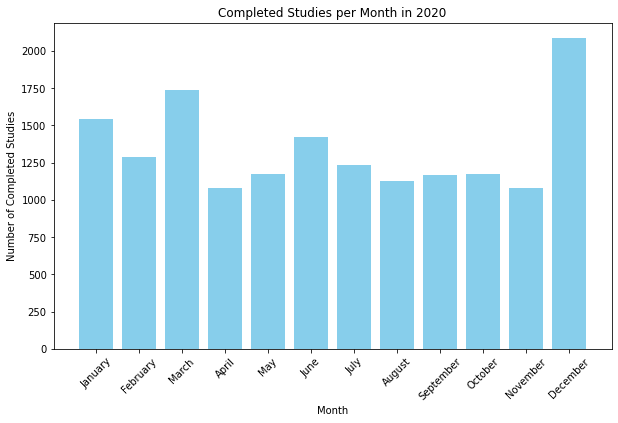


Completed Studies per Month:
+-----+-----+
|Month|count|
+-----+-----+
|    1| 1544|
|    2| 1286|
|    3| 1740|
|    4| 1080|
|    5| 1176|
|    6| 1424|
|    7| 1237|
|    8| 1126|
|    9| 1167|
|   10| 1176|
|   11| 1078|
|   12| 2084|
+-----+-----+



In [0]:
analysis_5_completed_studies_by_month()